# PJM Hourly Energy Consumption Case

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

### XGBoost Training Step - By Sabrina Otoni da Silva - 2024/04

In [50]:
from pathlib import Path

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

from xgboost import XGBRegressor

import joblib

import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf

In [18]:
datapath = Path('../data/d02_intermediate')

In [19]:
df = pd.read_csv(f'{datapath}/pjme_train.csv')
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [20]:
x = df[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'day', 'weekofyear', 'lag1', 'lag2', 'lag3']]
y = df['pjme_mw']

In [21]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [22]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [23]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
model = XGBRegressor(objective='reg:squarederror', base_score=0.5)

In [24]:
grid_params = {
              'booster': ['gbtree', 'dart'],
              'learning_rate': [0.01, 0.1],
              'subsample': [0, 0.6, 0.8],
              'max_depth': [3, 6, 9], 
              'gamma': [0.01, 0.1]
              }

grid_search = GridSearchCV(estimator=model, param_grid=grid_params, refit=True,
                           scoring=rmse_scorer, cv=tss, verbose=3, error_score='raise')

grid_search.fit(x, y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END booster=gbtree, gamma=0.01, learning_rate=0.01, max_depth=3, subsample=0;, score=-32327.836 total time=   0.1s
[CV 2/5] END booster=gbtree, gamma=0.01, learning_rate=0.01, max_depth=3, subsample=0;, score=-32077.817 total time=   0.1s
[CV 3/5] END booster=gbtree, gamma=0.01, learning_rate=0.01, max_depth=3, subsample=0;, score=-32378.621 total time=   0.2s
[CV 4/5] END booster=gbtree, gamma=0.01, learning_rate=0.01, max_depth=3, subsample=0;, score=-32071.413 total time=   0.2s
[CV 5/5] END booster=gbtree, gamma=0.01, learning_rate=0.01, max_depth=3, subsample=0;, score=-31230.684 total time=   0.2s
[CV 1/5] END booster=gbtree, gamma=0.01, learning_rate=0.01, max_depth=3, subsample=0.6;, score=-12006.502 total time=   0.2s
[CV 2/5] END booster=gbtree, gamma=0.01, learning_rate=0.01, max_depth=3, subsample=0.6;, score=-11879.131 total time=   0.2s
[CV 3/5] END booster=gbtree, gamma=0.01, learning_rate=0.01, max_d

GridSearchCV(cv=TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=8760),
             error_score='raise',
             estimator=XGBRegressor(base_score=0.5, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'booster': ['gbtree', 'dart'], 'gamma': [0.01, 0.1],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 6, 9],
                         'subsample': [0, 0.6, 0.8]},
             scoring=make_scorer(rmse, greater_is_better=False), verbose=3)

In [25]:
print(f'In {model}, the best params are: {grid_search.best_params_} with the best score being: {-grid_search.best_score_}')

In XGBRegressor(base_score=0.5, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), the best params are: {'booster': 'dart', 'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.6} with the best score being: 3778.3002137454505


In [26]:
modelpath = Path('../model')
with open(f'{modelpath}/xgboost_params.txt', 'w') as file:
    file.write(str(grid_search.best_params_))

In [30]:
joblib.dump(grid_search.best_estimator_, f'{modelpath}/xgboost_gs.pkl')

['..\\model/xgboost_gs.pkl']

In [67]:
xgb = joblib.load(f'{modelpath}/xgboost_gs.pkl')

In [68]:
test = pd.read_csv(f'{datapath}/pjme_test.csv')
test = test.set_index('datetime')
test.index = pd.to_datetime(test.index)
test = test.sort_index()

In [73]:
x_test = test[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'day', 'weekofyear', 'lag1', 'lag2', 'lag3']]
y_test = test['pjme_mw']

In [74]:
y_pred = xgb.predict(x_test)
y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=['Predicted'])

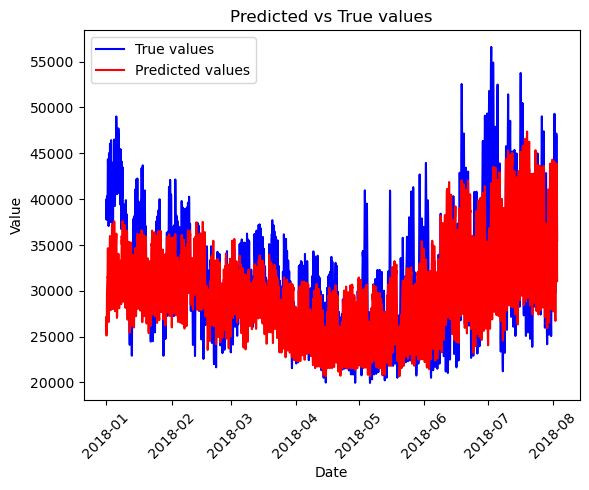

In [75]:
plt.plot(y_test.index, y_test.values, label='True values', color='blue')
plt.plot(y_test.index, y_pred['Predicted'].values, label='Predicted values', color='red')
plt.legend()
plt.title('Predicted vs True values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()

In [83]:
residuals = y_test - y_pred.values.flatten()

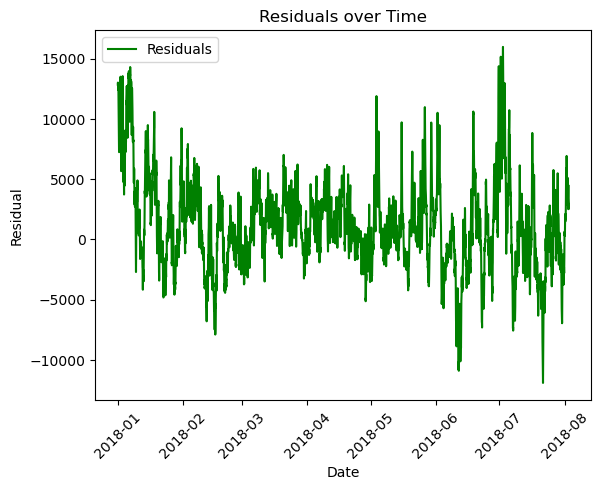

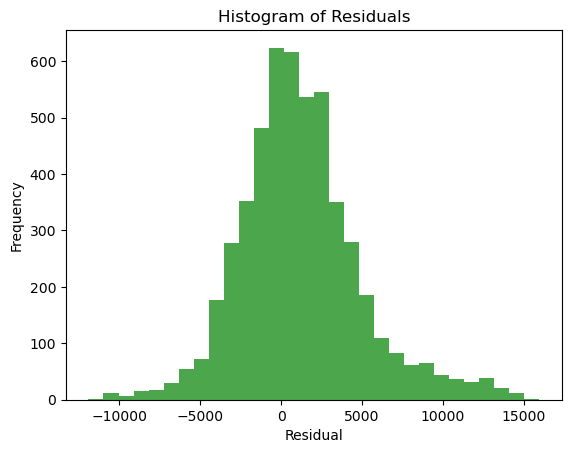

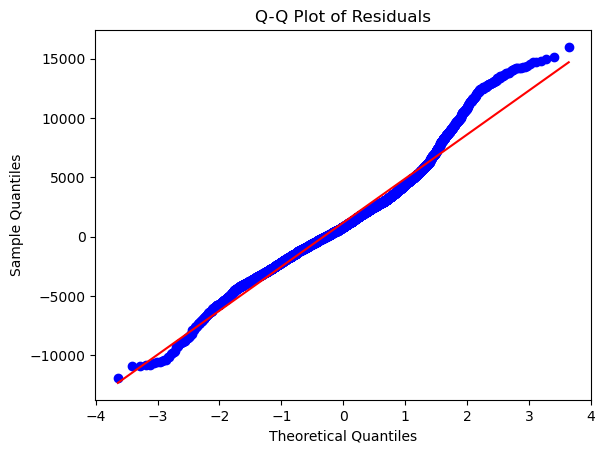

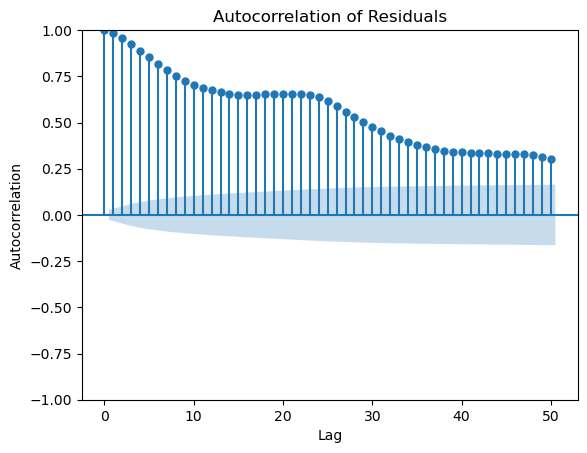

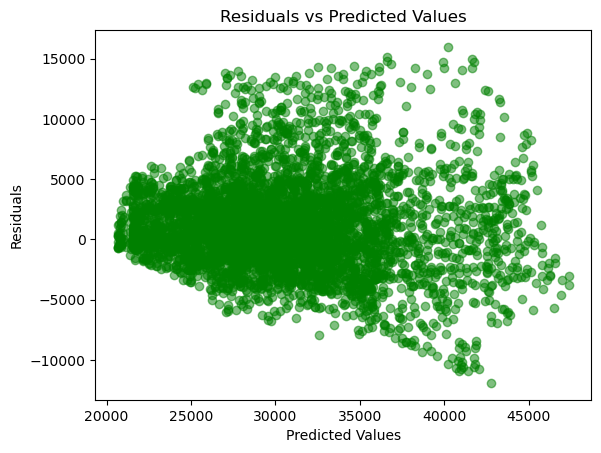

In [84]:
plt.plot(y_test.index, residuals, label='Residuals', color='green')
plt.title('Residuals over Time')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.hist(residuals, bins=30, color='green', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

plot_acf(residuals, lags=50)
plt.title('Autocorrelation of Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

plt.scatter(y_pred, residuals, color='green', alpha=0.5)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()